In [1]:
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66

libcudnn8:
  Installed: 8.1.1.33-1+cuda11.2
  Candidate: 8.6.0.163-1+cuda11.8
  Version table:
     8.6.0.163-1+cuda11.8 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.6.0.163-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda1

In [2]:
!nvidia-smi

Mon Oct 10 09:02:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [5]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/lung_image_set'

In [6]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [7]:
for layer in resnet.layers:
    layer.trainable = False

In [8]:
folders = glob('/content/drive/MyDrive/lung_image_set/*')

In [9]:
x = Flatten()(resnet.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)

In [14]:
training_set = data.flow_from_directory('/content/drive/MyDrive/lung_image_set',
                                                 target_size = (224, 224),
                                                 batch_size = 512,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 12016 images belonging to 3 classes.


In [15]:
test_set = data.flow_from_directory('/content/drive/MyDrive/lung_image_set',
                                            target_size = (224, 224),
                                            batch_size = 512,
                                            subset = "validation",
                                            class_mode = 'categorical')

Found 3003 images belonging to 3 classes.


In [16]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
24/24 [==============================] - 6334s 265s/step - loss: 3.9983 - accuracy: 0.3741 - val_loss: 1.0701 - val_accuracy: 0.5258
Epoch 2/10
24/24 [==============================] - 286s 12s/step - loss: 1.2418 - accuracy: 0.5459 - val_loss: 0.8640 - val_accuracy: 0.6400
Epoch 3/10
24/24 [==============================] - 287s 12s/step - loss: 0.7857 - accuracy: 0.6960 - val_loss: 0.7220 - val_accuracy: 0.7443
Epoch 4/10
24/24 [==============================] - 286s 12s/step - loss: 0.6892 - accuracy: 0.7383 - val_loss: 0.6688 - val_accuracy: 0.7150
Epoch 5/10
24/24 [==============================] - 283s 12s/step - loss: 0.6709 - accuracy: 0.7203 - val_loss: 0.6440 - val_accuracy: 0.7439
Epoch 6/10
24/24 [==============================] - 285s 12s/step - loss: 0.6149 - accuracy: 0.7569 - val_loss: 0.5968 - val_accuracy: 0.7642
Epoch 7/10
24/24 [==============================] - 278s 12s/step - loss: 0.5795 - accuracy: 0.7751 - val_loss: 0.5691 - val_accuracy: 0.7639
Epoc

In [17]:
import matplotlib.pyplot as plt

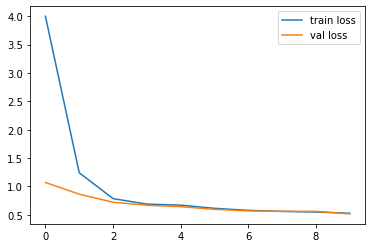

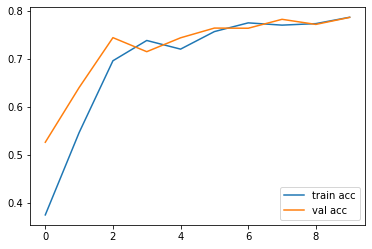

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [20]:
y_pred = model.predict(test_set)

6/6 [==============================] - 56s 9s/step


In [21]:
y_pred

array([[0.7889637 , 0.05383347, 0.15720285],
       [0.46367252, 0.46451277, 0.07181473],
       [0.30525887, 0.06275575, 0.6319854 ],
       ...,
       [0.38291678, 0.00677961, 0.6103036 ],
       [0.5550741 , 0.02360799, 0.4213179 ],
       [0.5674178 , 0.15067537, 0.2819068 ]], dtype=float32)

In [22]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_set.classes, y_pred))

6/6 [==============================] - 55s 9s/step
              precision    recall  f1-score   support

           0       0.33      0.37      0.35      1002
           1       0.33      0.29      0.31      1001
           2       0.34      0.34      0.34      1000

    accuracy                           0.34      3003
   macro avg       0.34      0.34      0.33      3003
weighted avg       0.34      0.34      0.33      3003



In [23]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix


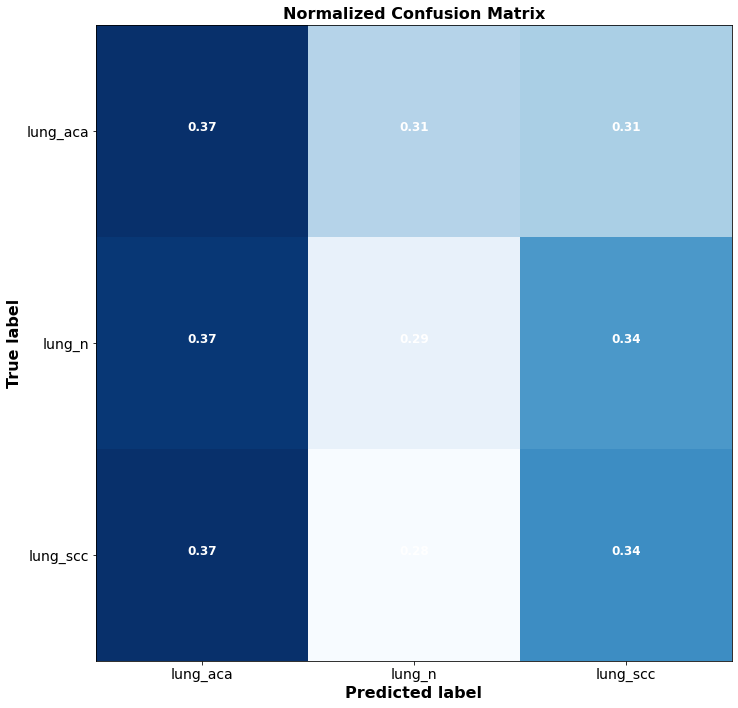

In [25]:
cnf_matrix = confusion_matrix(test_set.classes, y_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()